In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

import broadpy
from broadpy.utils import load_nirspec_resolution_profile

from extraction_tools import SpectralExtraction, combine_extractions

filters = {'g235h': 'f170lp', 'g395h': 'f290lp', 'g140h': 'f100lp'}

def get_filename(target, dither, grating, detector, suffix=None):
    filename = '/net/schenk/data2/regt/JWST_reductions/NIRSpec_ifu_reduction_23_09_2025/{0}/data/stage2/jw{1}_{2}_{3:05d}_{4}_{5}.fits'

    if target.lower() == 'vhs1256b':
        program = '01386013001'
        obs = {'g140h':'03106', 'g235h':'03102', 'g395h':'03104'}
        target = 'VHS1256b'

    elif target.lower() == 'std':
        program = '01128009001'
        obs = {'g140h':'03104', 'g235h':'03106', 'g395h':'03108'}
        target = 'std'

    if suffix is None:
        return (filename.format(target, program, obs[grating], dither, detector, 's3d'), 
                filename.format(target, program, obs[grating], dither, detector, 'x1d'))
    
    return filename.format(target, program, obs[grating], dither, detector, suffix)

def get_spectrum(file_s3d, file_x1d, grating, mask_radius=6, radius=4):
    SE = SpectralExtraction(file_s3d=file_s3d, file_wave=file_x1d, disperser=grating.upper(), filter=filters[grating], AC=None, N=2)
    # SE.AC.get_correction_factor = lambda *_: 1. # No aperture correction

    plot = 'std' not in file_s3d
    SE.correct_horizontal_background((9, 8), (26, 7), (10, 24), (27, 23), radius_inflation=mask_radius, plot=plot)
    SE.extract_1d(radius_inflation=radius, plot=False)

    return SE

def get_aperture_correction(wave_std, flux_std, err_std, grating):
    filename = '/net/schenk/data2/regt/JWST_reductions/NIRSpec_ifu_reduction_23_09_2025/std/1808347_mod_007.fits'
    hdu = fits.open(filename)
    wave_m = hdu[1].data['WAVELENGTH']*1e-4 # [Angstrom] to [micron]
    flux_m = hdu[1].data['FLUX'] * 1e-7 * (1e2)**2 * 1e4 # [erg/s/cm^2/Angstrom] to [W/m^2/micron]

    mask = (wave_m > 0.9) & (wave_m < 5.4)
    wave_m = wave_m[mask]; flux_m = flux_m[mask]

    # Instrumental broadening
    resolution_wave_grid, resolution = load_nirspec_resolution_profile(grating=grating.upper())
    IB = broadpy.InstrumentalBroadening(wave_m, flux_m)
    variable_resolution = np.interp(wave_m, resolution_wave_grid*1e-3, resolution)
    flux_m = IB(fwhm=2.998e5/variable_resolution, kernel='gaussian_variable')

    mask = np.isfinite(flux_std)
    flux_m = np.interp(wave_std, wave_m, flux_m)

    # p = np.polyfit(wave_std[mask], (flux_std/flux_m)[mask], deg=1, w=1/err_std[mask]**2)
    p = np.polyfit(wave_std[mask], (flux_std/flux_m)[mask], deg=0, w=1/err_std[mask]**2)
    AC = 1/np.polyval(p, wave_std)

    fig, ax = plt.subplots(figsize=(10,5), nrows=2, sharex=True, gridspec_kw={'height_ratios':[1,0.3], 'hspace':0.05})
    ax[0].plot(wave_std, flux_std, label='Observed')
    ax[0].plot(wave_std, flux_std*AC, label='Corrected')
    ax[0].plot(wave_std, flux_m, c='k', label='Model')
    ax[0].legend()
    ax[0].set(ylabel='Flux [W/m^2/micron]')
    ax[1].plot(wave_std, AC)
    ax[1].set(xlabel='Wavelength [micron]', ylabel='Aper. Corr.', ylim=(1,1.08))
    plt.show()
    
    return AC, p

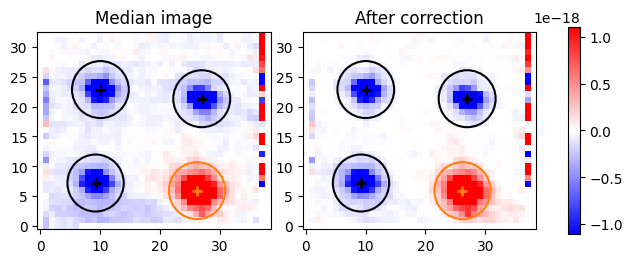

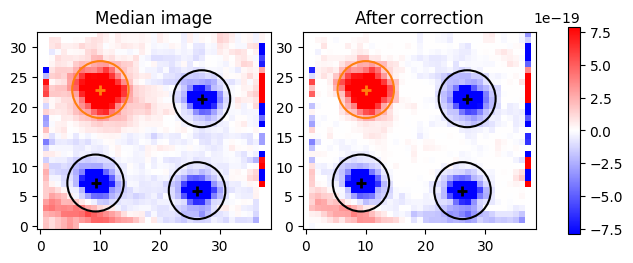

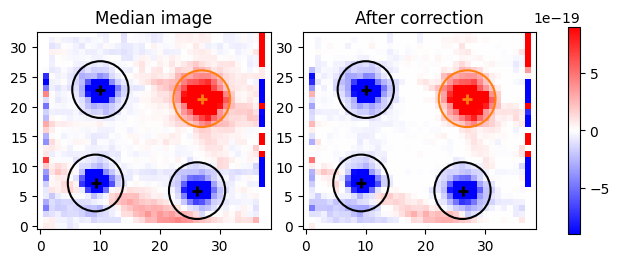

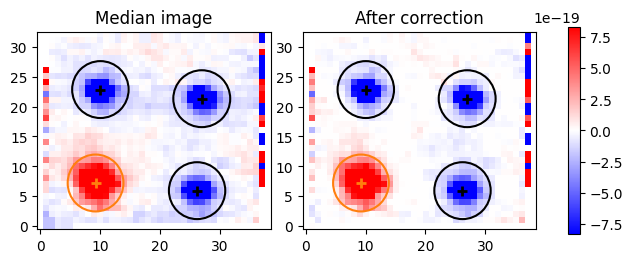

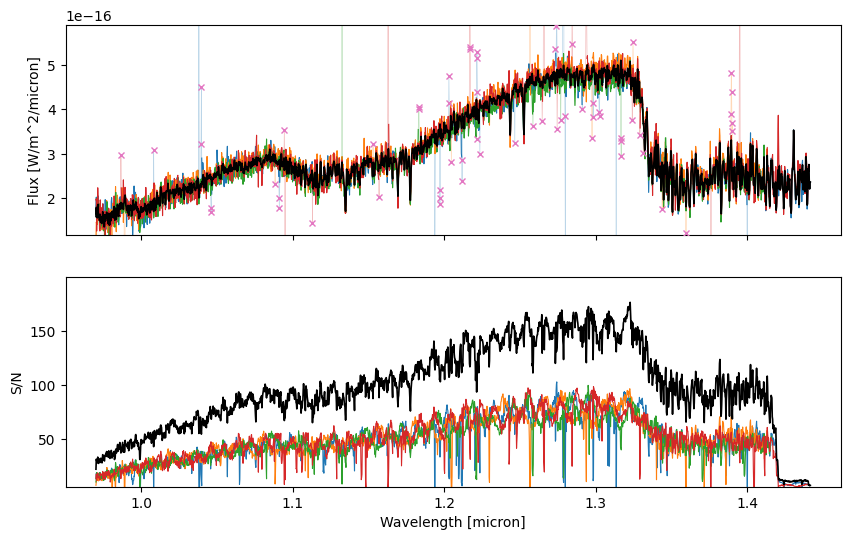

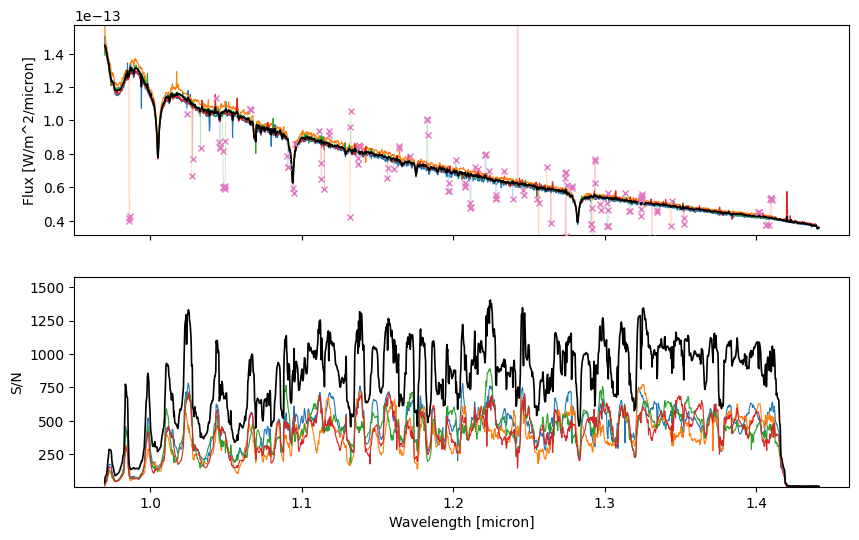

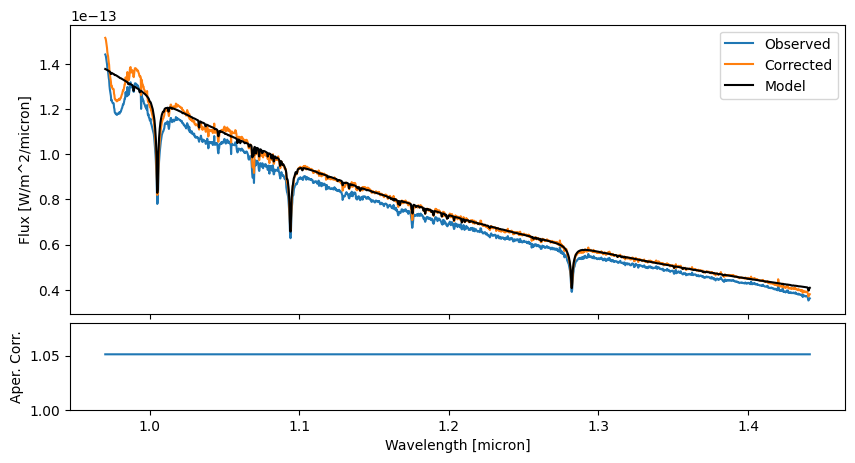

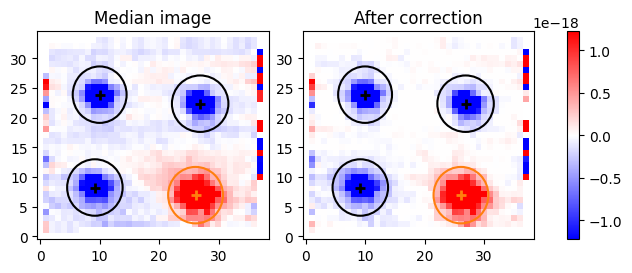

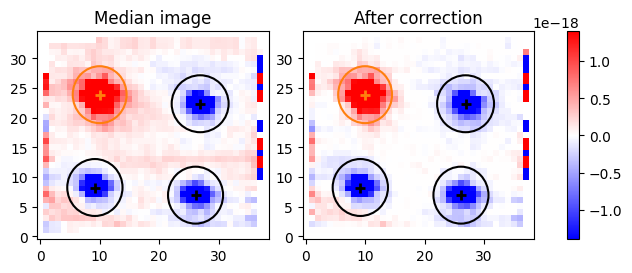

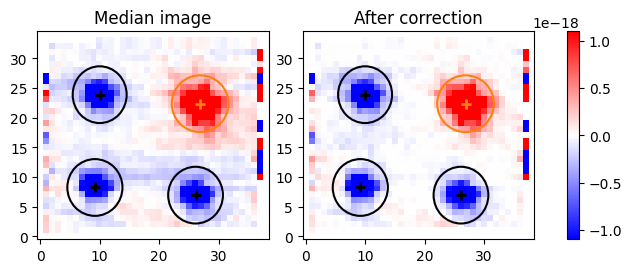

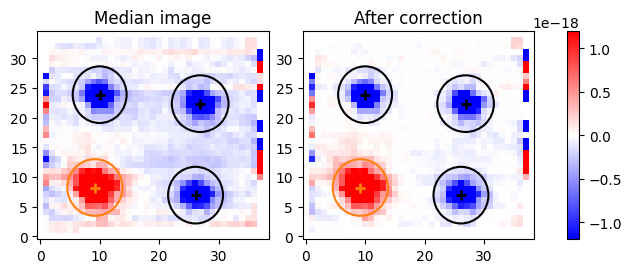

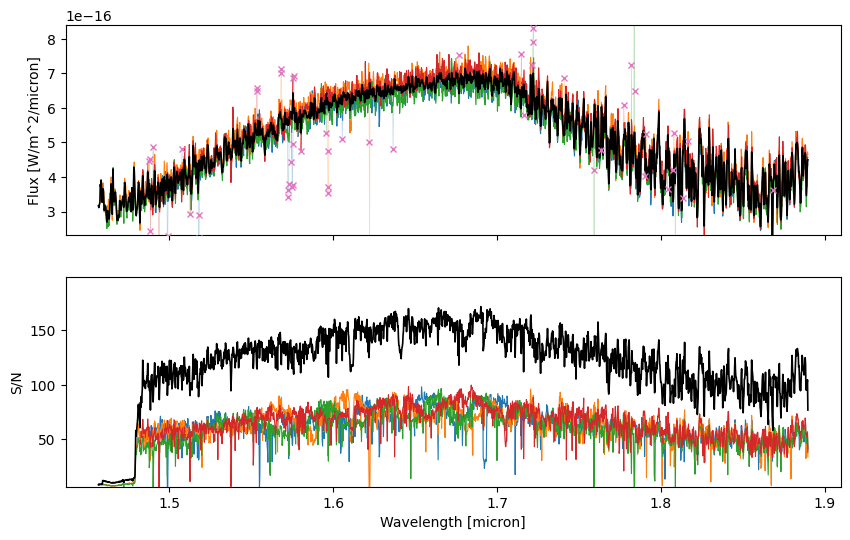

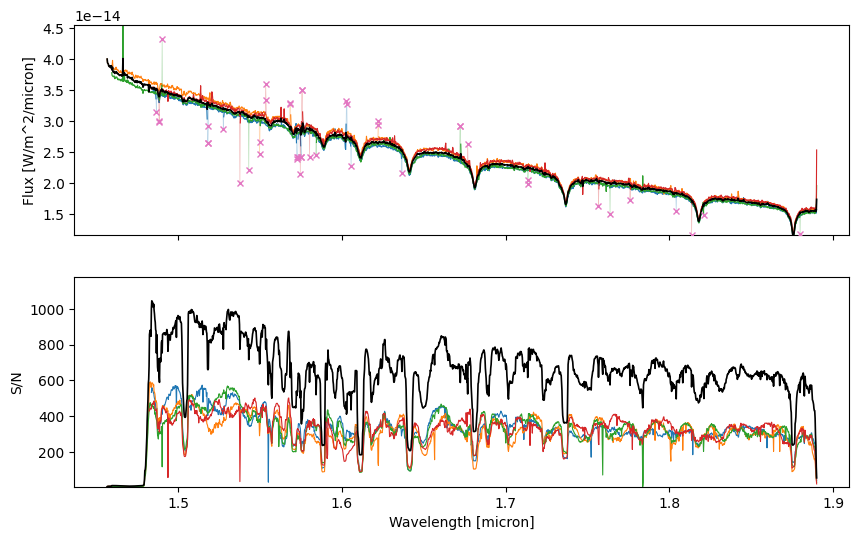

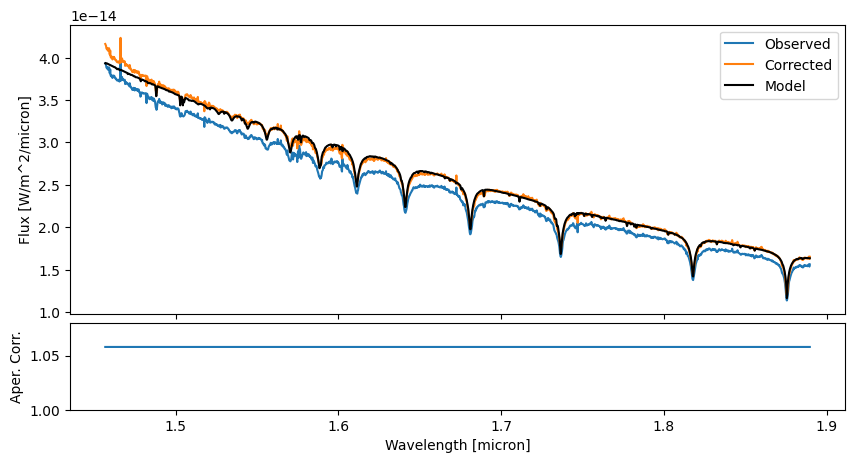

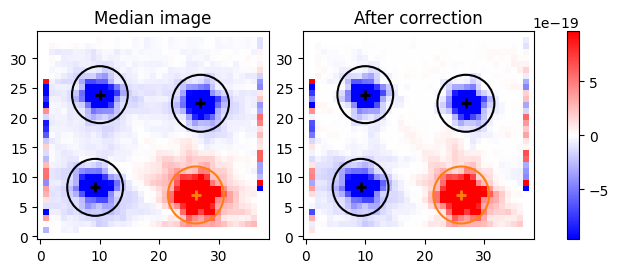

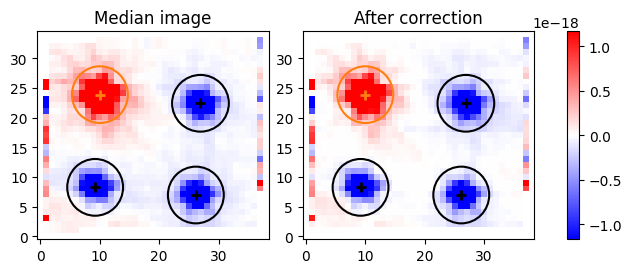

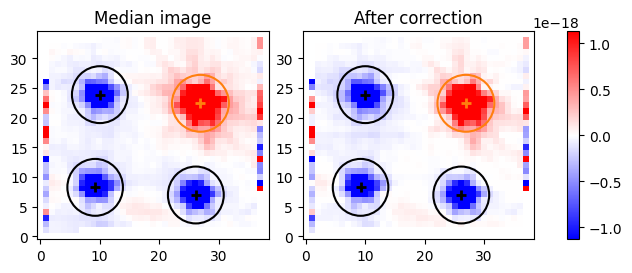

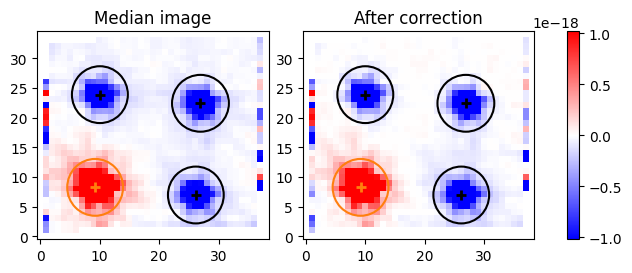

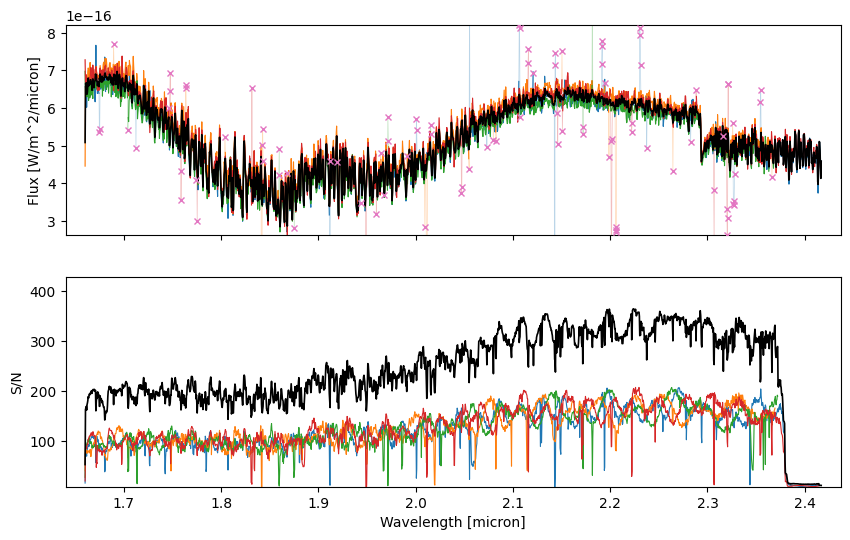

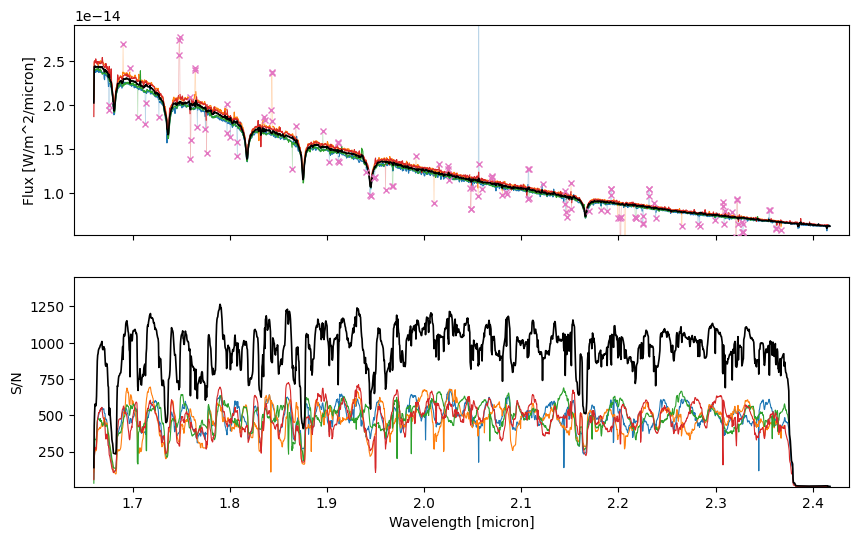

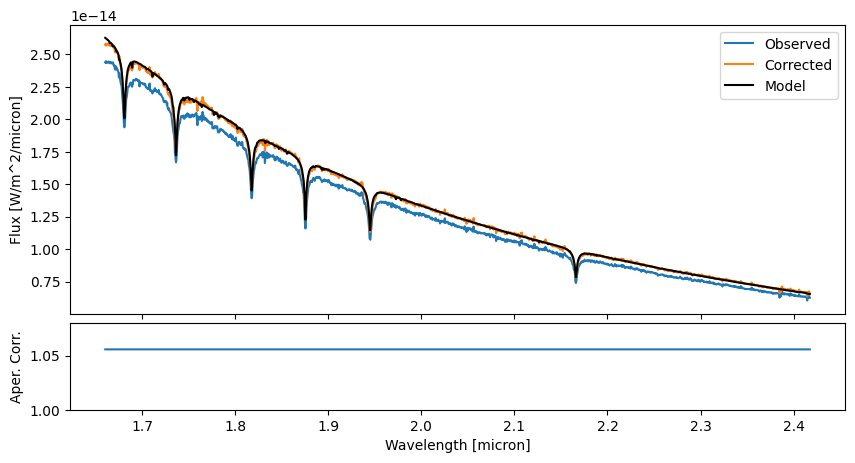

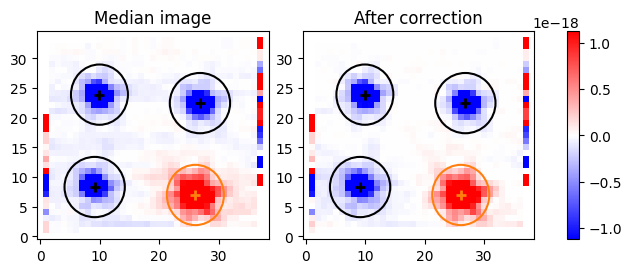

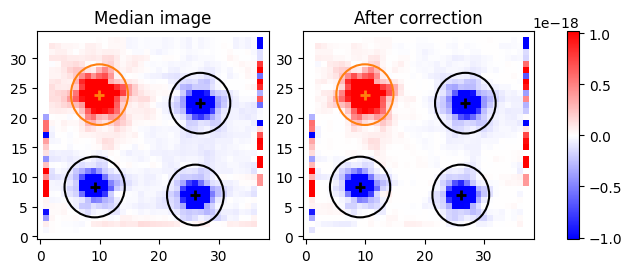

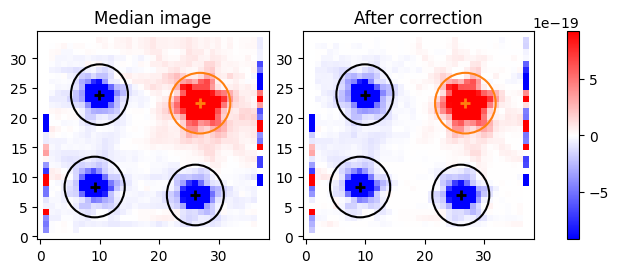

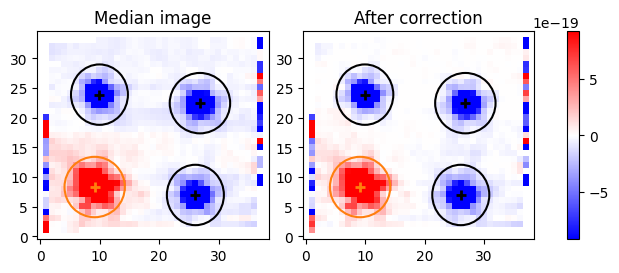

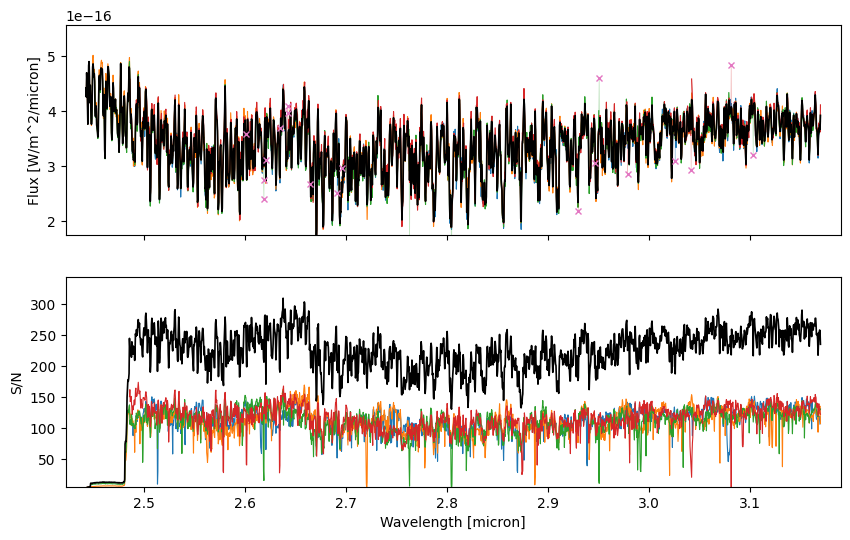

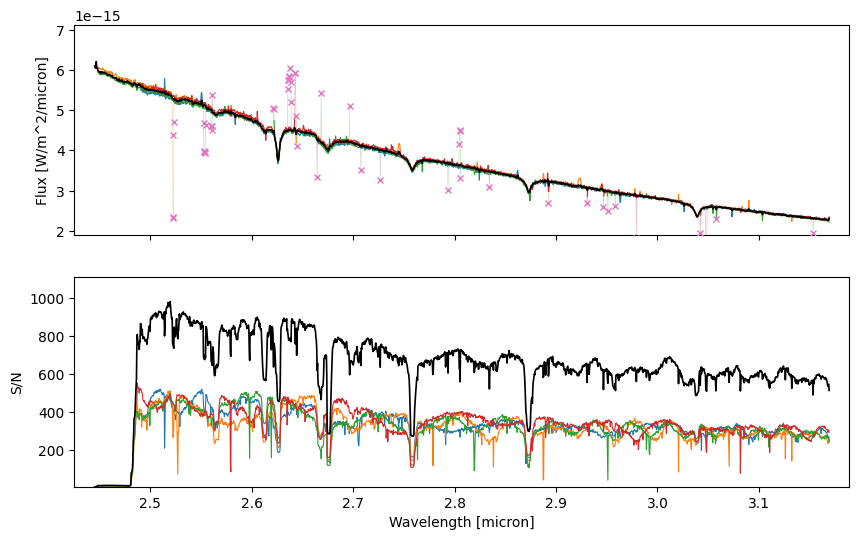

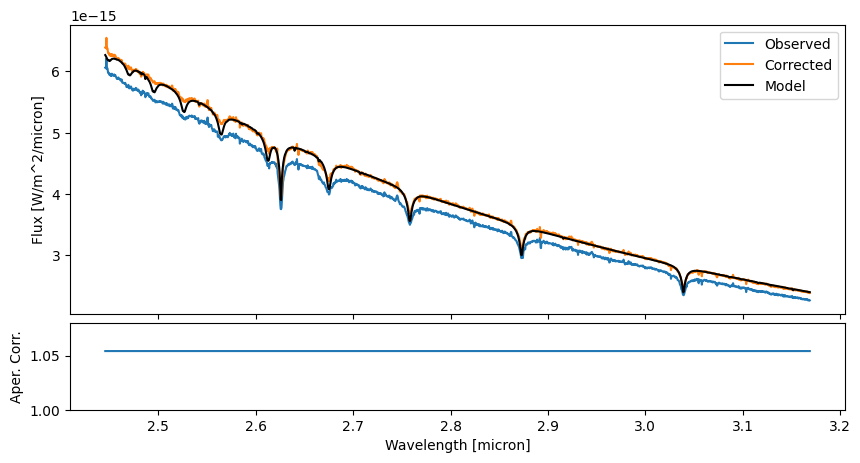

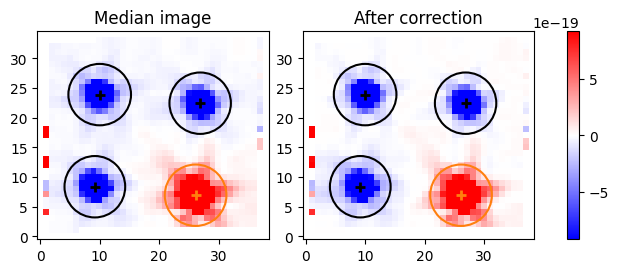

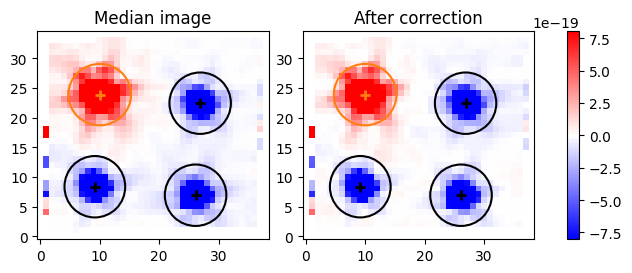

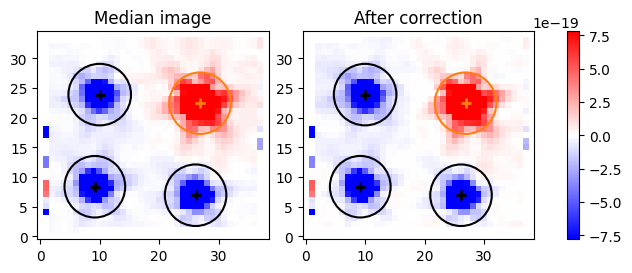

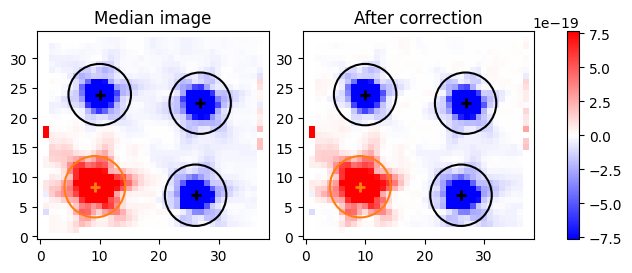

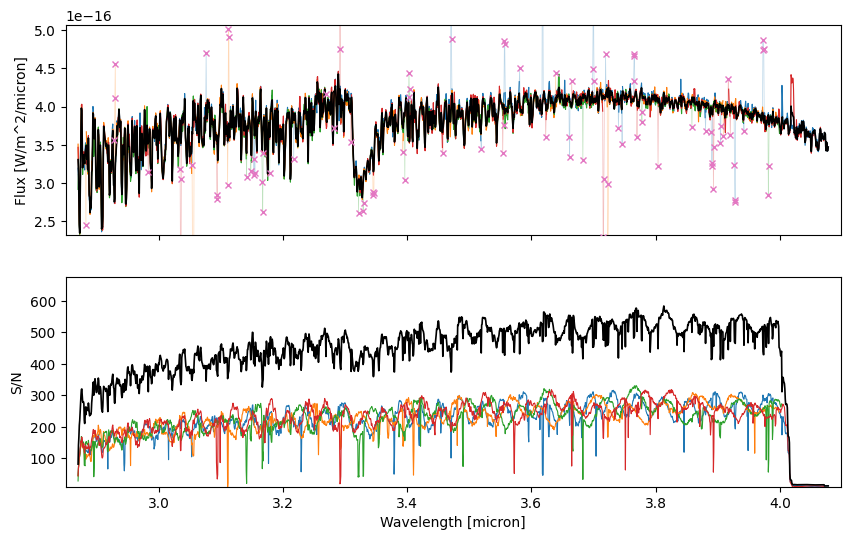

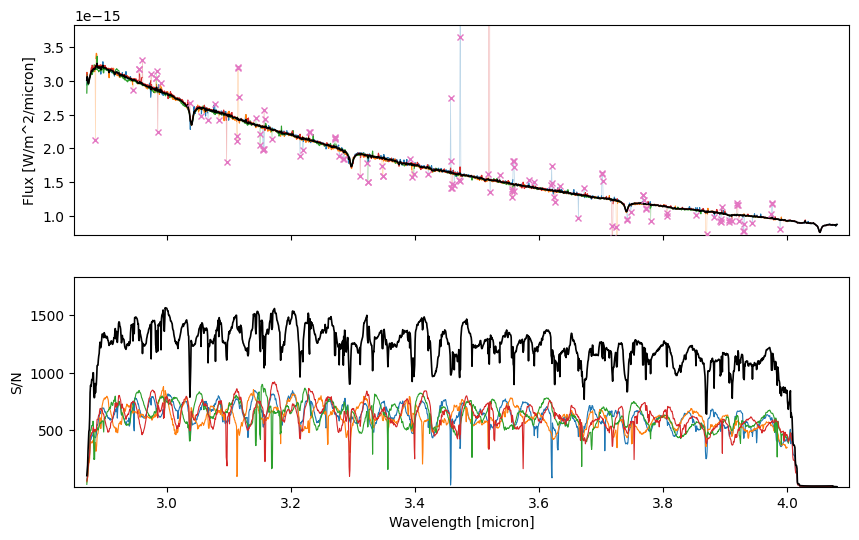

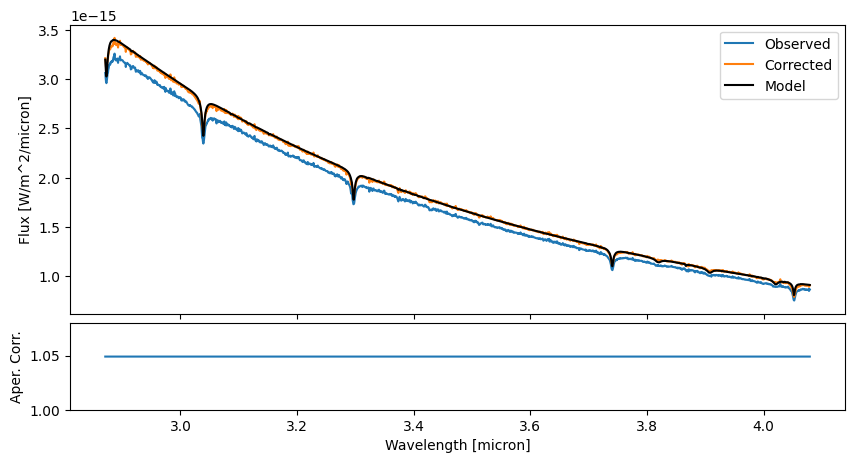

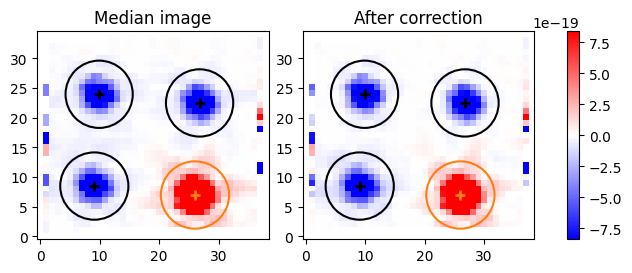

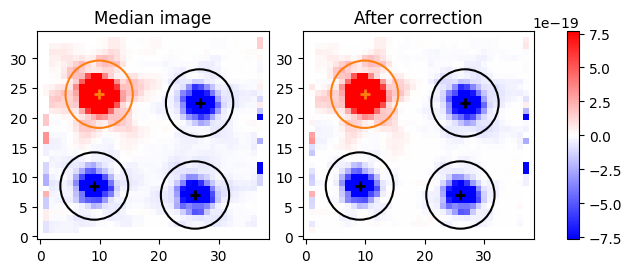

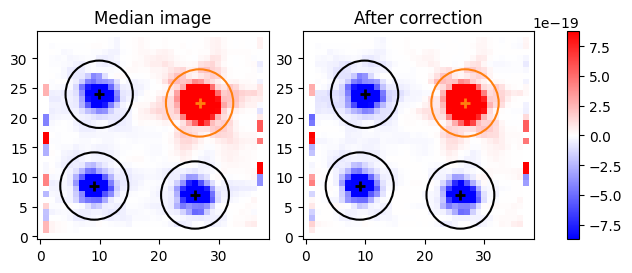

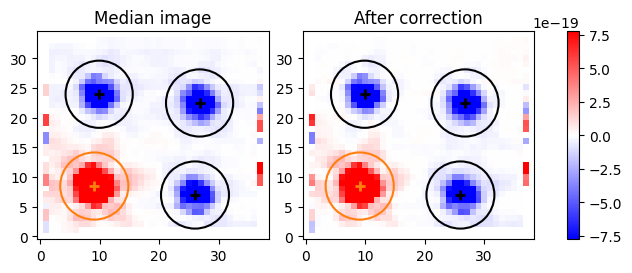

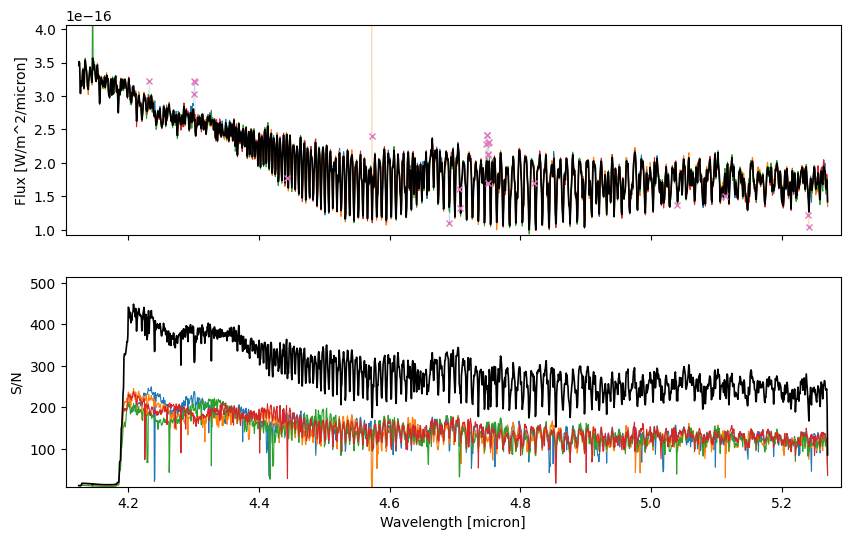

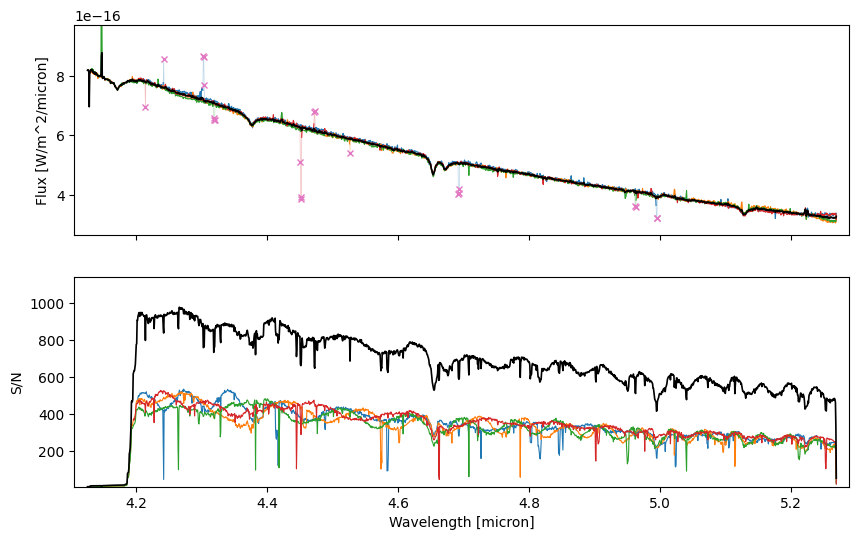

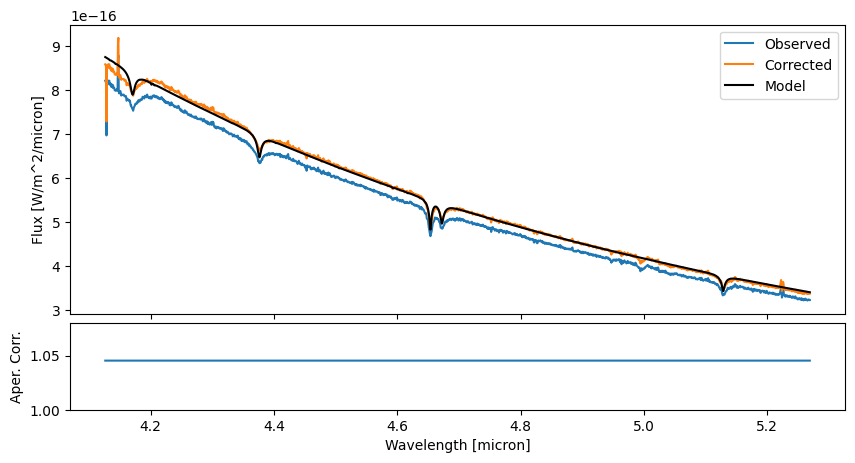

In [2]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=RuntimeWarning)

    for grating in ['g140h', 'g235h', 'g395h']:
        sigma_clip = {'g140h':10, 'g235h':13, 'g395h':16}[grating]

        for detector in ['nrs1', 'nrs2']:

            SEs = []; SEs_std = []
            for dither in [1,2,3,4]:
                file_s3d, file_x1d = get_filename('vhs1256b', dither, grating, detector)
                SE = get_spectrum(file_s3d, file_x1d, grating, mask_radius=6, radius=4)
                SEs.append(SE)

                file_s3d, file_x1d = get_filename('std', dither, grating, detector)
                SE_std = get_spectrum(file_s3d, file_x1d, grating, mask_radius=6, radius=4)
                SEs_std.append(SE_std)

            # Combine the dithering positions and save
            wave_combined, flux_combined, flux_err_combined = combine_extractions(*SEs, sigma_clip=sigma_clip, plot=True)
            wave_combined_std, flux_combined_std, flux_err_combined_std = combine_extractions(*SEs_std, sigma_clip=30, plot=True)

            AC, p = get_aperture_correction(wave_combined_std, flux_combined_std, flux_err_combined_std, grating)
            AC = 1/np.polyval(p, wave_combined)
            flux_combined *= AC
            flux_err_combined *= AC

            np.savetxt(
                '/net/schenk/data2/regt/JWST_reductions/NIRSpec_ifu_reduction_23_09_2025/VHS1256b/nirspec_{}_{}.dat'.format(grating[1:], detector[-1]), 
                # '/net/schenk/data2/regt/JWST_reductions/NIRSpec_ifu_reduction_23_09_2025/std/nirspec_{}_{}_wo_AC.dat'.format(grating[1:], detector[-1]), 
                np.array([wave_combined, flux_combined, flux_err_combined]).T, delimiter=',', 
                header='Wavelength (microns), Flux(W/m^2/microns), Flux Error(W/m^2/microns)', 
                )